In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('./Data/Ronaldo/18.jpg')
img.shape

(342, 233, 3)

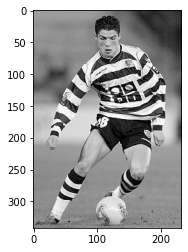

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [4]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')
face = face_cascade.detectMultiScale(gray, 1.3, 5)
face

array([[92, 24, 49, 49]], dtype=int32)

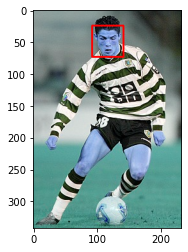

In [5]:
(x,y,w,h) = face[0]
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
plt.imshow(face_img)

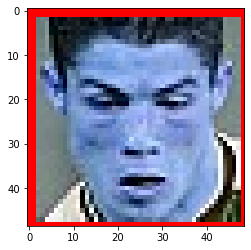

In [6]:
for (x,y,w,h) in face:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    croped_img = face_img[y:y+h, x:x+w]
    croped_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(croped_gray)
    for (ex, ey,ew, eh) in eyes:
        cv2.rectangle(croped_img, (ex,ey), (ex+ew, ey+eh), (0,255,0),2)
    

plt.figure()
plt.imshow(croped_img, cmap='gray')
plt.show()

In [15]:
def get_test_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x,y,w,h) in face:
        croped_img = img[y:y+h, x:x+w]
        croped_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(croped_gray)
        if(len(eyes) >= 2):
            return croped_img

cropped_img = get_test_image('./test/2-j.jpg')


In [16]:
data_path = "./Data/"
test_data_path = "./Data/test/"

In [21]:
import os
data_dir = []
for entry in os.scandir(data_path):
    if entry.is_dir():
        data_dir.append(entry.path)
data_dir

['./Data/Jackie-Chan', './Data/Ronaldo']

In [22]:
import shutil
if os.path.exists(test_data_path):
    shutil.rmtree(test_data_path)
os.mkdir(test_data_path)

In [23]:
cropped_image_dir =[]
data_name = {}

for d_dir in data_dir:
    count = 1
    cel_name = d_dir.split('/')[-1]
   
    
    data_name[cel_name] = []
    
    for i in os.scandir(d_dir):
        main_pic = get_test_image(i.path)
        if main_pic is not None:
            test_data_folder = test_data_path + cel_name
            if not os.path.exists(test_data_folder):
                os.mkdir(test_data_folder)
                print("\tTest Data folder create: ", test_data_folder)
                
            main_pic_name = cel_name + str(count) + ".png"
            main_pic_path = test_data_folder + "/" + main_pic_name
            
            cv2.imwrite(main_pic_path, main_pic)
           
            data_name[cel_name].append(main_pic_path)
            count += 1
            
    

	Test Data folder create:  ./Data/test/Jackie-Chan
	Test Data folder create:  ./Data/test/Ronaldo


In [29]:
import pywt
def w2d(img, mode="haar", level=1):
    imgArray = img
    imgArray = cv2.cvtColor(imgArray, cv2.COLOR_RGB2GRAY)
    imgArray = np.float32(imgArray)
    imgArray /=255;
    coeffs = pywt.wavedec2(imgArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    imgArray_H = pywt.waverec2(coeffs_H, mode)
    imgArray_H *= 255;
    imgArrayH = np.uint8(imgArray_H)
    return imgArray_H

In [ ]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [30]:
class_dict = {}
count = 0
for name in data_name.keys():
    class_dict[name] = count
    count += 1

In [31]:
x = []
y = []
for cele_name, training_files in data_name.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_image = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_har_img = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_image.reshape(32*32*3,1),
                                  scalled_har_img.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[cele_name])

In [32]:
x = np.array(x).reshape(len(x), 4096).astype(float)
x.shape

(61, 4096)

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [122]:
X_train, X_test,y_train, y_test = train_test_split(x, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [123]:
pipe.score(X_test, y_test)

0.8125

In [112]:
pipe.predict(X_test)


array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [88]:
y_test

[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]

In [38]:
class_dict

{'Jackie-Chan': 0, 'Ronaldo': 1}

(1, 4096)


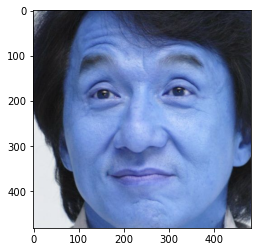

In [42]:
def prepare_image(img):
    t = []
#     img = cv2.imread(file_path)
    if img is None:
        return
    scalled_raw_image = cv2.resize(img, (32,32))
    img_har = w2d(img, 'db1', 5)
    scalled_har_img = cv2.resize(img_har, (32,32))
    combined_img = np.vstack((scalled_raw_image.reshape(32*32*3,1),
                              scalled_har_img.reshape(32*32,1)))

    t.append(combined_img)
    #         y.append(class_dict[cele_name])
    x = np.array(t).reshape(len(t), 4096).astype(float)
    print(x.shape)
    return x

new_img = get_test_image('./test/3-j.jpg')
#img = cv2.imread('./test/2-j.jpg')
plt.imshow(new_img, cmap='gray')
predict_image = prepare_image(new_img)

In [43]:
pipe.predict(predict_image)


array([0])